In [76]:
import pandas as pd
import numpy as np

import torch
from torchvision.transforms import v2

import random
import os
from tqdm import tqdm

from resnet_dataset import ResNetDataset
from resnet_model import ResNetClassifier

In [77]:
# Set random seeds for reproducibility
torch.manual_seed(21)
random.seed(21)

# Hyperparameters
dim = 20000                # Hypervector dimensionality
num_levels = 10              # Number of quantization levels for pixel intensities
batch_size = 128             # Batch size for training and testing
num_epochs = 10              # Number of training epochs
learning_rate = 0.001      # Learning rate for the optimizer (initial before scheduler)
workers = 8                 # Number of workers for the DataLoader
image_resize = (90, 120)   # Resize images to this size
percentage_to_train = 1   # Percentage of the dataset to use for training
train_split = 0.8      # Percentage of the training set to use for training
num_classes = 10       # Number of classes in the dataset
num_features = 256   # Number of features to extract from the images
use_gpu = torch.cuda.is_available()

# define path and percentage of data to use
path = 'data/'

## Build the Dataset

In [78]:
image_list = pd.read_csv(path + 'driver_imgs_list.csv')
image_list.drop(['subject'], axis=1, inplace=True) # Drop the 'subject' column

# keep only the numeric part of the 'classname' column
image_list['classname'] = image_list['classname'].str.extract(r'(\d+)').astype(int)
image_list = image_list.sample(frac=percentage_to_train, random_state=21) # Sample a fraction of the data

# divide image list into training and testing
train_size = int(train_split * len(image_list))
train_image_list = image_list[:train_size]
val_image_list = image_list[train_size:]

# reset the index of the dataframes
train_image_list.reset_index(drop=True, inplace=True)
val_image_list.reset_index(drop=True, inplace=True)

# Load the images
image_list.head()

,classname,img
8593,4,img_91307.jpg
943,2,img_49876.jpg
41,0,img_42895.jpg
7957,9,img_25333.jpg
10054,9,img_41804.jpg


In [79]:
train_path = 'data/imgs/train/'
val_path = 'data/imgs/train/'

# define the transformations
train_transform = v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ])

val_transform =  v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    ])

train_dataset = ResNetDataset(
    path=train_path,
    image_list=train_image_list,
    transform=train_transform
    )

val_dataset = ResNetDataset(
    path=val_path,
    image_list=val_image_list,
    transform=val_transform
    )

Loading images: 100%|██████████| 4485/4485 [00:10<00:00, 411.03it/s]


## Retran ResNet

In [80]:
model = ResNetClassifier(num_features, num_classes)

# Freeze all the layers except the final fully connected layer
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [81]:
from train import train

# check if model has already been trained
if os.path.exists(f'models/resnet_model_{num_features}.pth'):
    
    # Load the state dictionary
    state_dict = torch.load(f'models/resnet_model_{num_features}.pth', weights_only=True)
    # Remove 'model.' prefix from keys if it's causing the mismatch
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

    # Load the modified state dictionary
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    print('Model loaded')
    metrics = pd.read_csv(f'models/metrics_{num_features}.csv')
    print('Metrics: \n', metrics[-5:])
else:
    trained_model, metrics = train(model, train_dataset, val_dataset, num_epochs, batch_size, workers)
    
    # save the model
    trained_model.save(f'models/resnet_model_{num_features}.pth')
    # save the metrics
    metrics.to_csv(f'models/metrics_{num_features}.csv', index=False)
    

Model loaded
Metrics: 
    Epoch  Training Loss  Test Loss  Accuracy  Precision    Recall  F1-Score
5      6       0.008812   0.115983  0.969677   0.970250  0.969677  0.969731
6      7       0.007649   0.093167  0.974359   0.974470  0.974359  0.974319
7      8       0.004255   0.079819  0.978818   0.978892  0.978818  0.978802
8      9       0.004187   0.095436  0.973467   0.973601  0.973467  0.973439
9     10       0.000825   0.083452  0.977703   0.977833  0.977703  0.977703


## Extract Features from last layer

In [82]:
# remove the last layer of the model and replace with an identity layer
model.model.fc = torch.nn.Identity()

# get the features from the model
train_features = np.zeros((len(train_dataset), num_features))
train_labels = np.zeros(len(train_dataset))
val_features = np.zeros((len(val_dataset), num_features))

batch_size = 64

print('Train dataset length: ', len(train_dataset))
for i in tqdm(range(0, len(train_dataset), batch_size), desc='Extracting features from the training dataset'):
    images_list, label_list = train_dataset[i: i+batch_size]
    images = torch.stack(images_list, dim=0)
    features = model(images)
    train_features[i: i+batch_size] = features.detach().numpy()
    train_labels[i: i+batch_size] = label_list

print('Validation dataset length: ', len(val_dataset))
for i in tqdm(range(0, len(val_dataset), batch_size), desc='Extracting features from the validation dataset'):
    images_list, _ = val_dataset[i: i+batch_size]
    images = torch.stack(images_list, dim=0)
    features = model(images)
    val_features[i: i+batch_size] = features.detach().numpy()

Train dataset length:  17939


Extracting features from the training dataset: 100%|██████████| 281/281 [02:17<00:00,  2.04it/s]


Validation dataset length:  4485


Extracting features from the validation dataset: 100%|██████████| 71/71 [00:34<00:00,  2.09it/s]


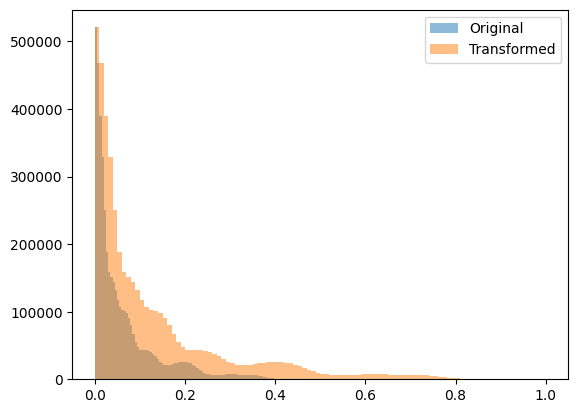

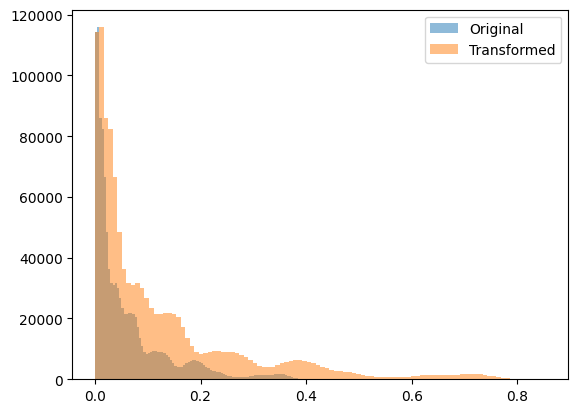

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
import matplotlib.pyplot as plt

# Define the pipeline with each scaler in order
scaler_pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

flat_train_features = train_features.flatten().reshape(-1, 1)

# normalize the features
transformed_train_features = scaler_pipeline.fit_transform(flat_train_features)

# plot the normalised scaled features
plt.hist(flat_train_features, bins=100, alpha=0.5, label='Original')
plt.hist(transformed_train_features, bins=100, alpha=0.5, label='Transformed')
plt.legend()
plt.show()

transformed_val_features = scaler_pipeline.transform(val_features.flatten().reshape(-1, 1))

# plot the normalised scaled features
plt.hist(val_features.flatten(), bins=100, alpha=0.5, label='Original')
plt.hist(transformed_val_features, bins=100, alpha=0.5, label='Transformed')
plt.legend()
plt.show()

transformed_train_features = transformed_train_features.reshape(-1, num_features)
transformed_val_features = transformed_val_features.reshape(-1, num_features)

In [84]:
# save the scaler pipeline
import joblib
joblib.dump(scaler_pipeline, f'models/scaler_pipeline_{num_features}.joblib')

['models/scaler_pipeline_256.joblib']

## Encode Features in Hyperdimensional Vectors

In [85]:
import importlib
import hd_computing  # Ensure this initial import is done

# Reload the module after making changes to hd_computing.py
importlib.reload(hd_computing)

# Re-import specific classes and functions
from hd_computing import HDComputing, create_level_hvs, create_position_hvs, encode_features, create_class_prototypes

hd = HDComputing(dim)

# create the level hypervectors
level_hvs = create_level_hvs(num_levels, hd)

# create the position hypervectors
position_hvs = create_position_hvs(num_features, hd)

In [86]:
train_encoded = np.zeros((len(transformed_train_features), dim))
val_encoded = np.zeros((len(transformed_val_features), dim))

batch_size = 256

# encode the features
for i in tqdm(range(0, len(transformed_train_features), batch_size), desc='Encoding training features'):
    encoded_features = encode_features(transformed_train_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    train_encoded[i: i+batch_size] = encoded_features

for i in tqdm(range(0, len(transformed_val_features), batch_size), desc='Encoding validation features'):
    encoded_features = encode_features(transformed_val_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    val_encoded[i: i+batch_size] = encoded_features

Encoding validation features: 100%|██████████| 18/18 [02:15<00:00,  7.53s/it]


## Build Class Prototypes to Infer from Hyperdimensional Vectors

In [87]:
class_prototypes  = create_class_prototypes(train_encoded, train_labels, num_classes, hd, pecentile=0.9, voting_threshold=0.5)

In [88]:
train_predicted = np.zeros(len(train_encoded))
test_predicted = np.zeros(len(val_encoded))

for i in tqdm(range(len(train_encoded))):
    hv = train_encoded[i]
    similarity = [hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]
    predicted_class = np.argmax(similarity)
    train_predicted[i] = predicted_class

for i in tqdm(range(len(val_encoded))):
    hv = val_encoded[i]
    similarity = [hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]
    predicted_class = np.argmax(similarity)
    test_predicted[i] = predicted_class

100%|██████████| 4485/4485 [00:00<00:00, 6186.45it/s]


In [89]:
# calculate the metrics
accuracy_train = np.sum(train_predicted == train_labels)/len(train_labels)
accuracy_test = np.sum(test_predicted == val_image_list['classname'])/len(val_image_list)

from sklearn.metrics import precision_recall_fscore_support

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels, train_predicted, average='weighted', zero_division=0)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(val_image_list['classname'], test_predicted, average='weighted', zero_division=0)

print(f'Precision on the training dataset: {train_precision:.4f}')
print(f'Recall on the training dataset: {train_recall:.4f}')
print(f'F1 score on the training dataset: {train_f1:.4f}')
print(f'Accuracy on the training dataset: {accuracy_train:.4f}')

print(f'Precision on the validation dataset: {test_precision:.4f}')
print(f'Recall on the validation dataset: {test_recall:.4f}')
print(f'F1 score on the validation dataset: {test_f1:.4f}')
print(f'Accuracy on the validation dataset: {accuracy_test:.4f}')


Precision on the training dataset: 0.1986
Recall on the training dataset: 0.1962
F1 score on the training dataset: 0.1890
Accuracy on the training dataset: 0.1962
Precision on the validation dataset: 0.2095
Recall on the validation dataset: 0.2004
F1 score on the validation dataset: 0.1844
Accuracy on the validation dataset: 0.2004


Similarity scores:  [0.829, 0.831, 0.827, 0.829, 0.826, 0.821, 0.828, 0.829, 0.826, 0.829]


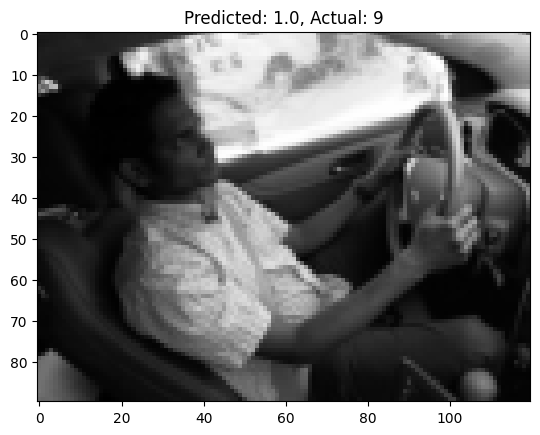

Similarity scores:  [0.798, 0.795, 0.798, 0.795, 0.798, 0.8, 0.798, 0.792, 0.801, 0.796]


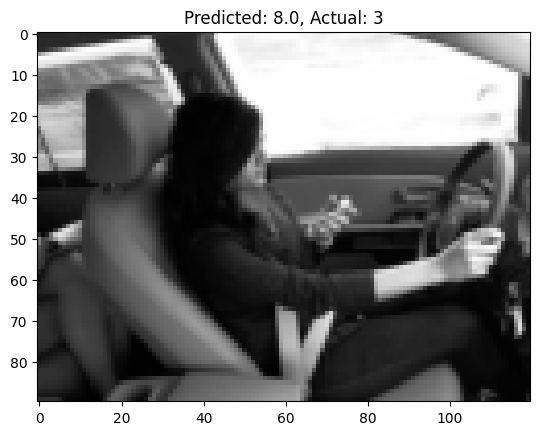

Similarity scores:  [0.8, 0.798, 0.803, 0.797, 0.801, 0.804, 0.802, 0.797, 0.802, 0.8]


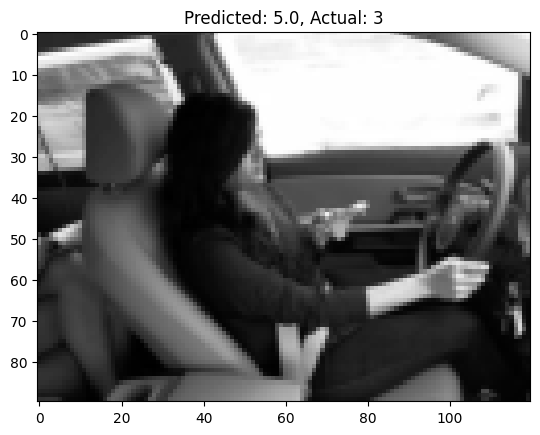

Similarity scores:  [0.824, 0.825, 0.823, 0.826, 0.824, 0.82, 0.823, 0.825, 0.819, 0.827]


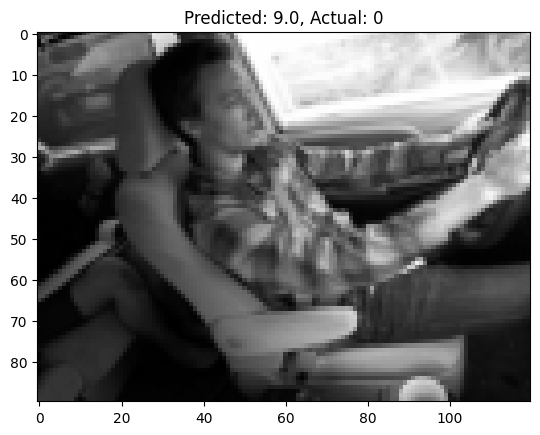

Similarity scores:  [0.826, 0.835, 0.833, 0.83, 0.825, 0.819, 0.832, 0.835, 0.83, 0.83]


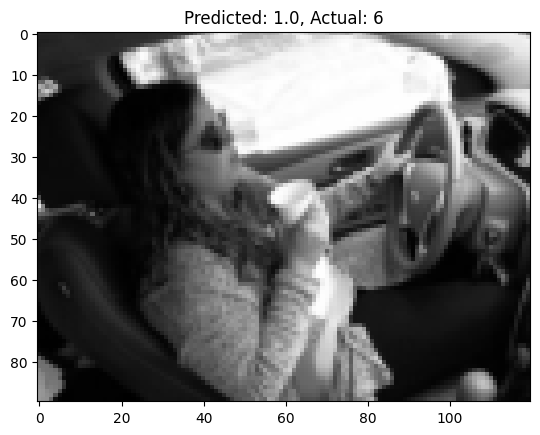

Similarity scores:  [0.819, 0.823, 0.825, 0.821, 0.822, 0.82, 0.823, 0.826, 0.822, 0.825]


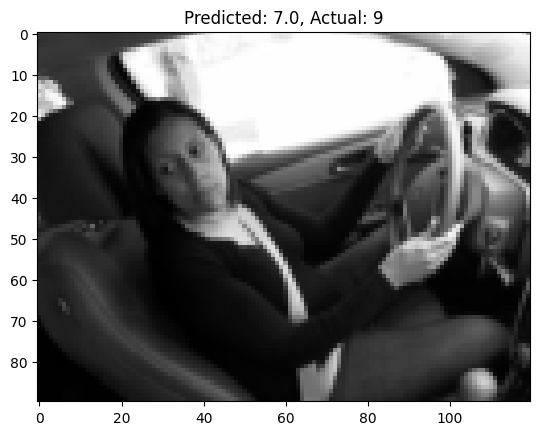

Similarity scores:  [0.822, 0.824, 0.826, 0.821, 0.821, 0.814, 0.824, 0.823, 0.823, 0.823]


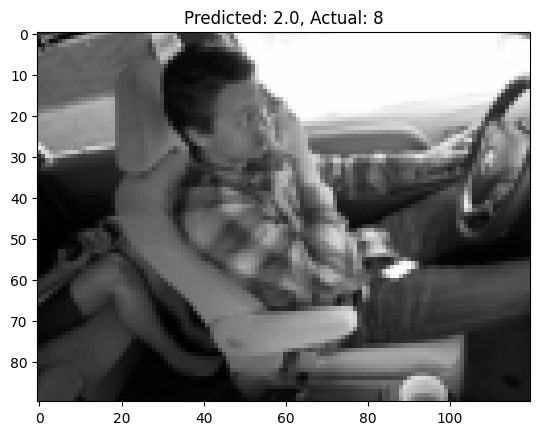

Similarity scores:  [0.806, 0.808, 0.811, 0.806, 0.805, 0.802, 0.811, 0.81, 0.81, 0.807]


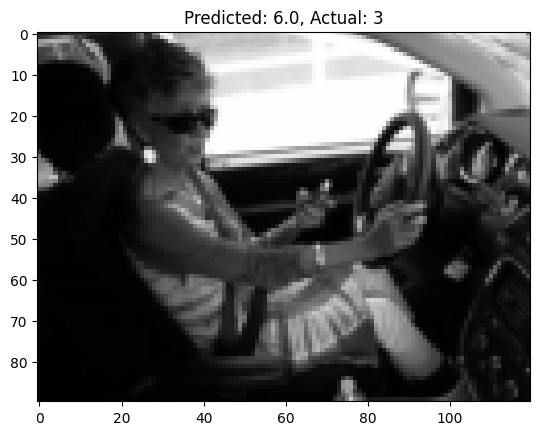

Similarity scores:  [0.823, 0.833, 0.83, 0.828, 0.822, 0.815, 0.83, 0.829, 0.827, 0.825]


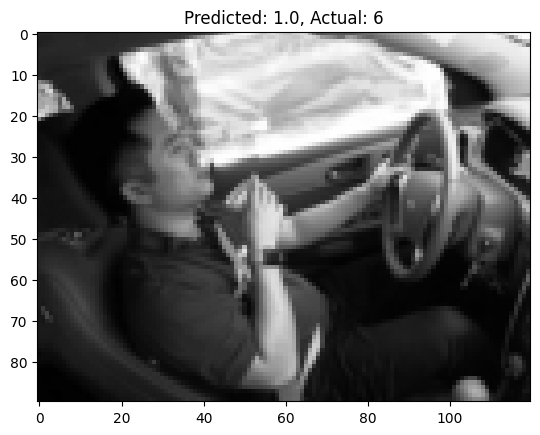

Similarity scores:  [0.825, 0.83, 0.832, 0.823, 0.827, 0.823, 0.831, 0.833, 0.833, 0.828]


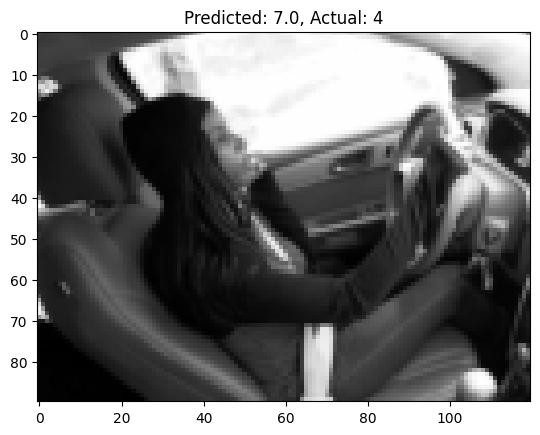

In [90]:
# find the indices of the misclassified images
mask = test_predicted != val_image_list['classname']
misclassified_indices = val_image_list[mask].index
misclassified_indices = misclassified_indices[:10]

# display the misclassified images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in misclassified_indices:
    image, label = val_dataset[i]
    plt.imshow(image[0], cmap='gray')
    plt.title(f'Predicted: {test_predicted[i]}, Actual: {label}')
    
    # print similarity scores
    hv = val_encoded[i]
    similarity = [round(float(hd.average_similarity(hv, class_prototypes[j])),3) for j in range(num_classes)]
    print('Similarity scores: ', similarity)
    plt.show()


## Label the Test Dataset for Kaggle Submission

In [91]:
from torchvision.io import read_image

path = 'data/imgs/test/'

# create an image list for the test dataset with all file names in the test folder
test_df = pd.DataFrame({'img': os.listdir(path)})

print('test image list: ', test_df.head())


transform = v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    ])

image_tensors = []
for i in tqdm(range(len(test_df)), desc='Loading test images'):
    image_path = path + test_df['img'][i]
    image = read_image(image_path)
    image = transform(image)
    image_tensors.append(image)

image_tensors = torch.stack(image_tensors, dim=0)

test image list:               img
0  img_60161.jpg
1  img_94786.jpg
2  img_85853.jpg
3  img_36327.jpg
4  img_39014.jpg


Loading test images:  71%|███████   | 56773/79726 [02:09<00:52, 436.73it/s]


KeyboardInterrupt: 

In [ ]:
test_features = np.zeros((len(test_df), num_features))
batch_size = 256

for i in tqdm(range(0, len(test_df), batch_size), desc='Extracting features from the test dataset'):
    images_list, _ = image_tensors[i: i+batch_size]
    images = torch.stack(images_list, dim=0)
    features = model(images)
    test_features[i: i+batch_size] = features.detach().numpy()


In [ ]:
flat_test_features = test_features.flatten().reshape(-1, 1)

# normalize the features
transformed_test_features = scaler_pipeline.transform(flat_test_features)

# plot the normalised scaled features
plt.hist(flat_test_features, bins=100, alpha=0.5, label='Original')
plt.hist(transformed_test_features, bins=100, alpha=0.5, label='Transformed')
plt.legend()

transformed_test_features = transformed_test_features.reshape(-1, num_features)
print('Transformed test features shape: ', transformed_test_features.shape)

In [ ]:
test_encoded = np.zeros((len(transformed_test_features), dim))

for i in tqdm(range(0, len(transformed_test_features), batch_size), desc='Encoding test features'):
    encoded_features = encode_features(transformed_test_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    test_encoded[i: i+batch_size] = encoded_features

In [ ]:
test_predictions = np.zeros(len(test_encoded), num_classes)

for i in tqdm(range(len(test_encoded))):
    hv = test_encoded[i]
    similarities = [hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]
    test_predictions[i] = similarities


# transform the similarities in probabilities using the softmax function
from scipy.special import softmax

test_probabilities = softmax(test_predictions, axis=1)

test_df = pd.DataFrame({
    'img': test_df['img'],
    'c0': test_probabilities[:, 0],
    'c1': test_probabilities[:, 1],
    'c2': test_probabilities[:, 2],
    'c3': test_probabilities[:, 3],
    'c4': test_probabilities[:, 4],
    'c5': test_probabilities[:, 5],
    'c6': test_probabilities[:, 6],
    'c7': test_probabilities[:, 7],
    'c8': test_probabilities[:, 8],
    'c9': test_probabilities[:, 9],
})

# export subission.csv
test_df.to_csv('data/submission.csv', index=False)